In [37]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.special import erf
import ipywidgets as widgets  # interactive display


In [38]:
def plot_accuracy_vs_stoptime(mu, sigma, stop_time_list, accuracy_analytical_list, accuracy_list=None):
    """Simulate and plot a SPRT for a fixed amount of times given a std.
  
    Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): Standard deviation of the observations.
      stop_time_list (int): List of number of steps to run before stopping.
      accuracy_analytical_list (int): List of analytical accuracies for each stop time
      accuracy_list (int (optional)): List of simulated accuracies for each stop time
    """
    T = stop_time_list[-1]
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_xlabel('Stop Time')
    ax.set_ylabel('Average Accuracy')
    ax.plot(stop_time_list, accuracy_analytical_list)
    if accuracy_list is not None:
        ax.plot(stop_time_list, accuracy_list)
    ax.legend(['analytical','simulated'], loc='upper center')

    # Show two gaussian
    stop_time_list_plot = [max(1,T//10), T*2//3]
    sigma_st_max = 2*mu*np.sqrt(stop_time_list_plot[-1])/sigma
    domain = np.linspace(-3*sigma_st_max,3*sigma_st_max,50)
    for stop_time in stop_time_list_plot:
        ins = ax.inset_axes([stop_time/T,0.05,0.2,0.3])
        for pos in ['right', 'top', 'bottom', 'left']:
            ins.spines[pos].set_visible(False)
        ins.axis('off')
        ins.set_title(f"stop_time={stop_time}")

        left = np.zeros_like(domain)
        mu_st = 4*mu*mu*stop_time/2/sigma**2
        sigma_st = 2*mu*np.sqrt(stop_time)/sigma
        for i, mu1 in enumerate([-mu_st,mu_st]):
            rv = stats.norm(mu1, sigma_st)
            offset = rv.pdf(domain)
            lbl = "summed evidence" if i == 1 else ""
            color = "crimson"
            ls = "solid" if i==1 else "dashed"
            ins.plot(domain, left+offset, label=lbl, color=color,ls=ls)

        rv = stats.norm(mu_st, sigma_st)
        domain0 = np.linspace(-3*sigma_st_max,0,50)
        offset = rv.pdf(domain0)
        ins.fill_between(domain0, np.zeros_like(domain0), offset, color="crimson", label="error")
        ins.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.show(fig)

In [39]:
def simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample,
                                     verbose=True):
    """Simulate and plot a SPRT for a fixed amount of time given a std.
  
    Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): Standard deviation of the observations.
      stop_time (int): Number of steps to run before stopping.
      num_sample (int): The number of samples to plot.
      """

    evidence_history_list = []
    if verbose:
        print("Trial\tTotal_Evidence\tDecision")
    for i in range(num_sample):
        evidence_history, decision, Mvec = simulate_SPRT_fixedtime(mu, sigma, stop_time)
        if verbose:
            print("{}\t{:f}\t{}".format(i, evidence_history[-1], decision))
        evidence_history_list.append(evidence_history)

    fig, ax = plt.subplots()
    maxlen_evidence = np.max(list(map(len,evidence_history_list)))
    ax.plot(np.zeros(maxlen_evidence), '--', c='red', alpha=1.0)
    for evidences in evidence_history_list:
        ax.plot(np.arange(len(evidences)), evidences)
        ax.set_xlabel("Time")
        ax.set_ylabel("Accumulated log likelihood ratio")
        ax.set_title("Log likelihood ratio trajectories under the fixed-time " +
                     "stopping rule")

    plt.show(fig)


def simulate_and_plot_SPRT_fixedthreshold(mu, sigma, num_sample, alpha,
                                          verbose=True):
    """Simulate and plot a SPRT for a fixed amount of times given a std.
  
    Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): Standard deviation of the observations.
      num_sample (int): The number of samples to plot.
      alpha (float): Threshold for making a decision.
    """
    # calculate evidence threshold from error rate
    threshold = threshold_from_errorrate(alpha)

    # run simulation
    evidence_history_list = []
    if verbose:
        print("Trial\tTime\tAccumulated Evidence\tDecision")
    for i in range(num_sample):
        evidence_history, decision, Mvec = simulate_SPRT_threshold(mu, sigma, threshold)
        if verbose:
            print("{}\t{}\t{:f}\t{}".format(i, len(Mvec), evidence_history[-1],
                                            decision))
        evidence_history_list.append(evidence_history)

    fig, ax = plt.subplots()
    maxlen_evidence = np.max(list(map(len,evidence_history_list)))
    ax.plot(np.repeat(threshold,maxlen_evidence + 1), c="red")
    ax.plot(-np.repeat(threshold,maxlen_evidence + 1), c="red")
    ax.plot(np.zeros(maxlen_evidence + 1), '--', c='red', alpha=0.5)

    for evidences in evidence_history_list:
        ax.plot(np.arange(len(evidences) + 1), np.concatenate([[0], evidences]))

    ax.set_xlabel("Time")
    ax.set_ylabel("Accumulated log likelihood ratio")
    ax.set_title("Log likelihood ratio trajectories under the threshold rule")

    plt.show(fig)


def simulate_and_plot_accuracy_vs_threshold(mu, sigma, threshold_list, num_sample):
    """Simulate and plot a SPRT for a set of thresholds given a std.
  
    Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): Standard deviation of the observations.
      alpha_list (float): List of thresholds for making a decision.
      num_sample (int): The number of samples to plot.
    """
    accuracies, decision_speeds = simulate_accuracy_vs_threshold(mu, sigma,
                                                                 threshold_list,
                                                                 num_sample)

    # Plotting
    fig, ax = plt.subplots()
    ax.plot(decision_speeds, accuracies, linestyle="--", marker="o")
    ax.plot([np.amin(decision_speeds), np.amax(decision_speeds)],
            [0.5, 0.5], c='red')
    ax.set_xlabel("Average Decision speed")
    ax.set_ylabel('Average Accuracy')
    ax.set_title("Speed/Accuracy Tradeoff")
    ax.set_ylim(0.45, 1.05)

    plt.show(fig)


def threshold_from_errorrate(alpha):
    """Calculate log likelihood ratio threshold from desired error rate `alpha`
  
    Args:
      alpha (float): in (0,1), the desired error rate
  
    Return:
      threshold: corresponding evidence threshold
    """
    threshold = np.log((1. - alpha) / alpha)
    return threshold

Trial	Total_Evidence	Decision
0	-1.825211	-1.0
1	3.033974	1.0
2	1.121418	1.0
3	1.978989	1.0
4	-0.699630	-1.0
5	1.214701	1.0
6	0.773329	1.0
7	0.727977	1.0
8	2.286441	1.0
9	2.611457	1.0


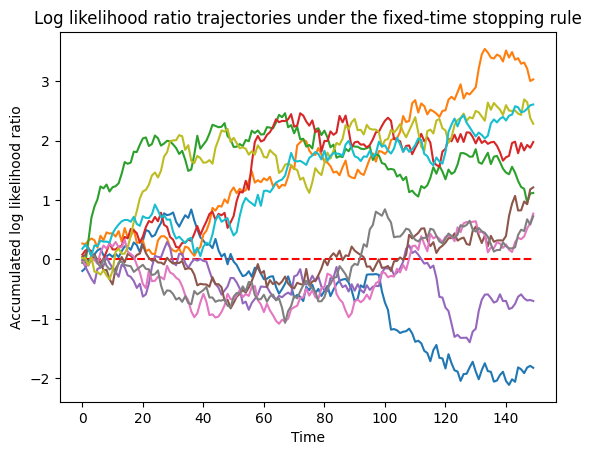

In [40]:
def log_likelihood_ratio(Mvec, p0, p1):
    """Given a sequence(vector) of observed data, calculate the log of
    likelihood ratio of p1 and p0
  
    Args:
      Mvec (numpy vector):           A vector of scalar measurements
      p0 (Gaussian random variable): A normal random variable with `logpdf'
                                      method
      p1 (Gaussian random variable): A normal random variable with `logpdf`
                                      method
  
    Returns:
      llvec: a vector of log likelihood ratios for each input data point
    """
    return p1.logpdf(Mvec) - p0.logpdf(Mvec)


def simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist = 1):
    """Simulate a Sequential Probability Ratio Test with fixed time stopping
    rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
    N(-1,sigma^2).
  
    Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): Standard deviation of observation models
      stop_time (int): Number of samples to take before stopping
      true_dist (1 or -1): Which state is the true state.
  
    Returns:
      evidence_history (numpy vector): the history of cumulated evidence given
                                        generated data
      decision (int): 1 for s = 1, -1 for s = -1
      Mvec (numpy vector): the generated sequences of measurement data in this trial
    """

    # Set means of observation distributions
    assert mu > 0, "Mu should be > 0"
    mu_pos = mu
    mu_neg = -mu

    # Make observation distributions
    p_pos = stats.norm(loc = mu_pos, scale = sigma)
    p_neg = stats.norm(loc = mu_neg, scale = sigma)

    # Generate a random sequence of measurements
    if true_dist == 1:
        Mvec = p_pos.rvs(size = stop_time)
    else:
        Mvec = p_neg.rvs(size = stop_time)

    # Calculate log likelihood ratio for each measurement (delta_t)
    ll_ratio_vec = log_likelihood_ratio(Mvec, p_neg, p_pos)

    # STEP 1: Calculate accumulated evidence (S) given a time series of evidence (hint: np.cumsum)
    evidence_history = np.cumsum(ll_ratio_vec)

    # STEP 2: Make decision based on the sign of the evidence at the final time.
    decision = np.sign(evidence_history[-1])

    return evidence_history, decision, Mvec


# Set random seed
np.random.seed(100)

# Set model parameters
mu = .2
sigma = 3.5  # standard deviation for p+ and p-
num_sample = 10  # number of simulations to run
stop_time = 150 # number of steps before stopping

# Simulate and visualize
simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time, num_sample)

In [41]:
def simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist=1):
    """Simulate a Sequential Probability Ratio Test with fixed time stopping
    rule. Two observation models are 1D Gaussian distributions N(1,sigma^2) and
    N(-1,sigma^2).
  
    Args:
      mu (float): absolute mean value of the symmetric observation distributions
      sigma (float): Standard deviation of observation models
      stop_time (int): Number of samples to take before stopping
      true_dist (1 or -1): Which state is the true state.
  
    Returns:
      evidence_history (numpy vector): the history of cumulated evidence given
                                        generated data
      decision (int): 1 for s = 1, -1 for s = -1
      Mvec (numpy vector): the generated sequences of measurement data in this trial
    """

    # Set means of observation distributions
    assert mu > 0, "Mu should be >0"
    mu_pos = mu
    mu_neg = -mu

    # Make observation distributions
    p_pos = stats.norm(loc = mu_pos, scale = sigma)
    p_neg = stats.norm(loc = mu_neg, scale = sigma)

    # Generate a random sequence of measurements
    if true_dist == 1:
        Mvec = p_pos.rvs(size = stop_time)
    else:
        Mvec = p_neg.rvs(size = stop_time)

    # Calculate log likelihood ratio for each measurement (delta_t)
    ll_ratio_vec = log_likelihood_ratio(Mvec, p_neg, p_pos)

    # STEP 1: Calculate accumulated evidence (S) given a time series of evidence (hint: np.cumsum)
    evidence_history = np.cumsum(ll_ratio_vec)

    # STEP 2: Make decision based on the sign of the evidence at the final time.
    decision = np.sign(evidence_history[-1])

    return evidence_history, decision, Mvec


np.random.seed(100)
num_sample = 10

@widgets.interact(mu=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=0.5),
                  sigma=(0.05, 10.0, 0.05), stop_time=(5, 500, 1))
def plot(mu, sigma, stop_time):
    simulate_and_plot_SPRT_fixedtime(mu, sigma, stop_time,
                                     num_sample, verbose=False)

interactive(children=(FloatSlider(value=0.5, description='mu', max=5.0, min=0.1), FloatSlider(value=5.0, descr…

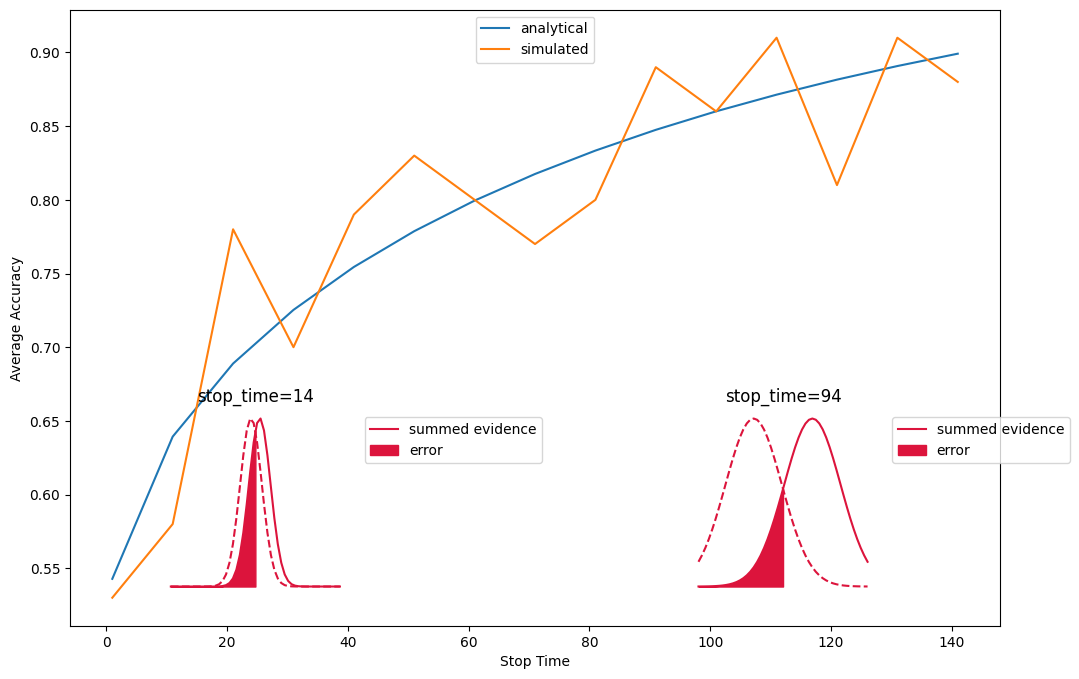

In [42]:
def simulate_accuracy_vs_stoptime(mu, sigma, stop_time_list, num_sample,
                                  no_numerical=False):
    """Calculate the average decision accuracy vs. stopping time by running
    repeated SPRT simulations for each stop time.
  
    Args:
        mu (float): absolute mean value of the symmetric observation distributions
        sigma (float): standard deviation for observation model
        stop_list_list (list-like object): a list of stopping times to run over
        num_sample (int): number of simulations to run per stopping time
        no_numerical (bool): flag that indicates the function to return analytical values only
  
    Returns:
        accuracy_list: a list of average accuracies corresponding to input
                        `stop_time_list`
        decisions_list: a list of decisions made in all trials
    """

    # Determine true state (1 or -1)
    true_dist = 1

    # Set up tracker of accuracy and decisions
    accuracies = np.zeros(len(stop_time_list),)
    accuracies_analytical = np.zeros(len(stop_time_list),)
    decisions_list = []

    # Loop over stop times
    for i_stop_time, stop_time in enumerate(stop_time_list):

        if not no_numerical:
            # Set up tracker of decisions for this stop time
            decisions = np.zeros((num_sample,))

            # Loop over samples
            for i in range(num_sample):

                # STEP 1: Simulate run for this stop time (hint: use output from last exercise)
                _, decision, _= simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist)

                # Log decision
                decisions[i] = decision

            # STEP 2: Calculate accuracy by averaging over trials
            accuracies[i_stop_time] = np.mean(decisions == (true_dist * np.ones_like(decisions)))

            # Log decision
            decisions_list.append(decisions)

        # Calculate analytical accuracy
        sigma_sum_gaussian = sigma / np.sqrt(stop_time)
        accuracies_analytical[i_stop_time] = 0.5 + 0.5 * erf(mu / np.sqrt(2) / sigma_sum_gaussian)

    return accuracies, accuracies_analytical, decisions_list


# Set random seed
np.random.seed(100)

# Set parameters of model
mu = 0.5
sigma = 4.65  # standard deviation for observation noise
num_sample = 100  # number of simulations to run for each stopping time
stop_time_list = np.arange(1, 150, 10) # Array of stopping times to use


# Calculate accuracies for each stop time
accuracies, accuracies_analytical, _ = simulate_accuracy_vs_stoptime(mu, sigma, stop_time_list,
                                                                     num_sample)

# Visualize
plot_accuracy_vs_stoptime(mu, sigma, stop_time_list, accuracies_analytical, accuracies)

In [43]:

def simulate_accuracy_vs_stoptime(mu, sigma, stop_time_list,
                                  num_sample, no_numerical=False):
    """Calculate the average decision accuracy vs. stopping time by running
    repeated SPRT simulations for each stop time.
  
    Args:
        mu (float): absolute mean value of the symmetric observation distributions
        sigma (float): standard deviation for observation model
        stop_list_list (list-like object): a list of stopping times to run over
        num_sample (int): number of simulations to run per stopping time
        no_numerical (bool): flag that indicates the function to return analytical values only
  
    Returns:
        accuracy_list: a list of average accuracies corresponding to input
                        `stop_time_list`
        decisions_list: a list of decisions made in all trials
    """

    # Determine true state (1 or -1)
    true_dist = 1

    # Set up tracker of accuracy and decisions
    accuracies = np.zeros(len(stop_time_list),)
    accuracies_analytical = np.zeros(len(stop_time_list),)
    decisions_list = []

    # Loop over stop times
    for i_stop_time, stop_time in enumerate(stop_time_list):

        if not no_numerical:
            # Set up tracker of decisions for this stop time
            decisions = np.zeros((num_sample,))

            # Loop over samples
            for i in range(num_sample):

                # Simulate run for this stop time (hint: last exercise)
                _, decision, _= simulate_SPRT_fixedtime(mu, sigma, stop_time, true_dist)

                # Log decision
                decisions[i] = decision

            # Calculate accuracy
            accuracies[i_stop_time] = np.sum(decisions == true_dist) / decisions.shape[0]
            # Log decisions
            decisions_list.append(decisions)

        # Calculate analytical accuracy
        sigma_sum_gaussian = sigma / np.sqrt(stop_time)
        accuracies_analytical[i_stop_time] = 0.5 + 0.5 * erf(mu / np.sqrt(2) / sigma_sum_gaussian)

    return accuracies, accuracies_analytical, decisions_list


np.random.seed(100)
num_sample = 100
stop_time_list = np.arange(1, 100, 1)

@widgets.interact
def plot(mu=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0),
         sigma=(0.05, 10.0, 0.05)):
    # Calculate accuracies for each stop time
    _, accuracies_analytical, _ = simulate_accuracy_vs_stoptime(mu, sigma,
                                                                stop_time_list,
                                                                num_sample,
                                                                no_numerical=True)
    # Visualize
    plot_accuracy_vs_stoptime(mu, sigma, stop_time_list, accuracies_analytical)

interactive(children=(FloatSlider(value=1.0, description='mu', max=5.0, min=0.1), FloatSlider(value=5.0, descr…

In [44]:
import numpy as np
import time
from scipy import stats
from scipy.optimize import linear_sum_assignment
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib import patches
import ipywidgets as widgets  # interactive display
from ipywidgets import interactive, interact, HBox, Layout,VBox

In [45]:
def plot_hmm1(model, states, measurements, flag_m=True):
    """Plots HMM states and measurements for 1d states and measurements.
  
    Args:
      model (hmmlearn model):               hmmlearn model used to get state means.
      states (numpy array of floats):       Samples of the states.
      measurements (numpy array of floats): Samples of the states.
    """
    T = states.shape[0]
    nsteps = states.size
    aspect_ratio = 2
    fig, ax1 = plt.subplots(figsize=(8,4))
    states_forplot = list(map(lambda s: model.means[s], states))
    ax1.step(np.arange(nstep), states_forplot, "-", where="mid", alpha=1.0, c="green")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Latent State", c="green")
    ax1.set_yticks([-1, 1])
    ax1.set_yticklabels(["-1", "+1"])
    ax1.set_xticks(np.arange(0,T,10))
    ymin = min(measurements)
    ymax = max(measurements)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Measurements", c="crimson")

    # show measurement gaussian
    if flag_m:
        ax2.plot([T,T],ax2.get_ylim(), color="maroon", alpha=0.6)
        for i in range(model.n_components):
            mu = model.means[i]
            scale = np.sqrt(model.vars[i])
            rv = stats.norm(mu, scale)
            num_points = 50
            domain = np.linspace(mu-3*scale, mu+3*scale, num_points)

            left = np.repeat(float(T), num_points)
            # left = np.repeat(0.0, num_points)
            offset = rv.pdf(domain)
            offset *= T / 15
            lbl = "measurement" if i == 0 else ""
            # ax2.fill_betweenx(domain, left, left-offset, alpha=0.3, lw=2, color="maroon", label=lbl)
            ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="maroon", label=lbl)
            ax2.scatter(np.arange(nstep), measurements, c="crimson", s=4)
            ax2.legend(loc="upper left")
        ax1.set_ylim(ax2.get_ylim())
    plt.show(fig)


def plot_marginal_seq(predictive_probs, switch_prob):
    """Plots the sequence of marginal predictive distributions.
  
      Args:
        predictive_probs (list of numpy vectors): sequence of predictive probability vectors
        switch_prob (float):                      Probability of switching states.
    """
    T = len(predictive_probs)
    prob_neg = [p_vec[0] for p_vec in predictive_probs]
    prob_pos = [p_vec[1] for p_vec in predictive_probs]
    fig, ax = plt.subplots()
    ax.plot(np.arange(T), prob_neg, color="blue")
    ax.plot(np.arange(T), prob_pos, color="orange")
    ax.legend([
        "prob in state -1", "prob in state 1"
    ])
    ax.text(T/2, 0.05, "switching probability={}".format(switch_prob), fontsize=12,
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.6))
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.set_title("Forgetting curve in a changing world")
    plt.show(fig)


def plot_evidence_vs_noevidence(posterior_matrix, predictive_probs):
    """Plots the average posterior probabilities with evidence v.s. no evidence
  
    Args:
      posterior_matrix: (2d numpy array of floats): The posterior probabilities in state 1 from evidence (samples, time)
      predictive_probs (numpy array of floats):  Predictive probabilities in state 1 without evidence
    """
    nsample, T = posterior_matrix.shape
    posterior_mean = posterior_matrix.mean(axis=0)
    fig, ax = plt.subplots(1)
    ax.plot([0.0, T], [0., 0.], color="red", linestyle="dashed")
    ax.plot(np.arange(T), predictive_probs, c="orange", linewidth=2, label="No evidence")
    ax.scatter(np.tile(np.arange(T), (nsample, 1)), posterior_matrix, s=0.8,
               c="green", alpha=0.3, label="With evidence(Sample)")
    ax.plot(np.arange(T), posterior_mean, c='green',
            linewidth=2, label="With evidence(Average)")
    ax.legend()
    ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability in State +1")
    ax.set_title("Gain confidence with evidence")
    plt.show(fig)


def plot_forward_inference(model, states, measurements, states_inferred,
                           predictive_probs, likelihoods, posterior_probs,
                           t=None, flag_m=True, flag_d=True, flag_pre=True,
                           flag_like=True, flag_post=True):
    """Plot ground truth state sequence with noisy measurements, and ground truth states v.s. inferred ones
  
        Args:
            model (instance of hmmlearn.GaussianHMM): an instance of HMM
            states (numpy vector): vector of 0 or 1(int or Bool), the sequences of true latent states
            measurements (numpy vector of numpy vector): the un-flattened Gaussian measurements at each time point, element has size (1,)
            states_inferred (numpy vector): vector of 0 or 1(int or Bool), the sequences of inferred latent states
    """
    T = states.shape[0]
    if t is None:
        t = T-1
    nsteps = states.size
    fig, ax1 = plt.subplots(figsize=(11,6))
    # true states
    states_forplot = list(map(lambda s: model.means[s], states))
    ax1.step(np.arange(nstep)[:t+1], states_forplot[:t+1], "-", where="mid", alpha=1.0, c="green", label="true")
    ax1.step(np.arange(nstep)[t+1:], states_forplot[t+1:], "-", where="mid", alpha=0.3, c="green", label="")
    # Posterior curve
    delta = model.means[1] - model.means[0]
    states_interpolation = model.means[0] + delta * posterior_probs[:,1]
    if flag_post:
        ax1.step(np.arange(nstep)[:t+1], states_interpolation[:t+1], "-", where="mid", c="grey", label="posterior")

    ax1.set_xlabel("Time")
    ax1.set_ylabel("Latent State", c="green")
    ax1.set_yticks([-1, 1])
    ax1.set_yticklabels(["-1", "+1"])
    ax1.legend(bbox_to_anchor=(0,1.02,0.2,0.1), borderaxespad=0, ncol=2)

    ax2 = ax1.twinx()
    ax2.set_ylim(
        min(-1.2, np.min(measurements)),
        max(1.2, np.max(measurements))
    )
    if flag_d:
        ax2.scatter(np.arange(nstep)[:t+1], measurements[:t+1], c="crimson", s=4, label="measurement")
        ax2.set_ylabel("Measurements", c="crimson")

    # show measurement distributions
    if flag_m:
        for i in range(model.n_components):
            mu = model.means[i]
            scale = np.sqrt(model.vars[i])
            rv = stats.norm(mu, scale)
            num_points = 50
            domain = np.linspace(mu-3*scale, mu+3*scale, num_points)

            left = np.repeat(float(T), num_points)
            offset = rv.pdf(domain)
            offset *= T /15
            lbl = ""
            ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="maroon", label=lbl)
    ymin, ymax = ax2.get_ylim()
    width = 0.1 * (ymax-ymin) / 2.0
    centers = [-1.0, 1.0]
    bar_scale = 15

    # Predictions
    data = predictive_probs
    if flag_pre:
        for i in range(model.n_components):
            domain = np.array([centers[i]-1.5*width, centers[i]-0.5*width])
            left = np.array([t,t])
            offset = np.array([data[t,i]]*2)
            offset *= bar_scale
            lbl = "todays prior" if i == 0 else ""
            ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="dodgerblue", label=lbl)

    # Likelihoods
    data = likelihoods
    data /= np.sum(data,axis=-1, keepdims=True)
    if flag_like:
        for i in range(model.n_components):
            domain = np.array([centers[i]+0.5*width, centers[i]+1.5*width])
            left = np.array([t,t])
            offset = np.array([data[t,i]]*2)
            offset *= bar_scale
            lbl = "likelihood" if i == 0 else ""
            ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="crimson", label=lbl)
    # Posteriors
    data = posterior_probs
    if flag_post:
        for i in range(model.n_components):
            domain = np.array([centers[i]-0.5*width, centers[i]+0.5*width])
            left = np.array([t,t])
            offset = np.array([data[t,i]]*2)
            offset *= bar_scale
            lbl = "posterior" if i == 0 else ""
            ax2.fill_betweenx(domain, left+offset, left, alpha=0.3, lw=2, color="grey", label=lbl)
    if t<T-1:
        ax2.plot([t,t],ax2.get_ylim(), color='black',alpha=0.6)
    if flag_pre or flag_like or flag_post:
        ax2.plot([t,t],ax2.get_ylim(), color='black',alpha=0.6)

        ax2.legend(bbox_to_anchor=(0.4,1.02,0.6, 0.1), borderaxespad=0, ncol=4)
    ax1.set_ylim(ax2.get_ylim())
    return fig
    # plt.show(fig)

In [46]:
GaussianHMM1D = namedtuple('GaussianHMM1D', ['startprob', 'transmat','means','vars','n_components'])

def create_HMM(switch_prob=0.1, noise_level=1e-1, startprob=[1.0, 0.0]):
    """Create an HMM with binary state variable and 1D Gaussian measurements
    The probability to switch to the other state is `switch_prob`. Two
    measurement models have mean 1.0 and -1.0 respectively. `noise_level`
    specifies the standard deviation of the measurement models.
  
    Args:
        switch_prob (float): probability to jump to the other state
        noise_level (float): standard deviation of measurement models. Same for
        two components
  
    Returns:
        model (GaussianHMM instance): the described HMM
    """

    n_components = 2

    startprob_vec = np.asarray(startprob)

    # STEP 1: Transition probabilities
    transmat_mat = np.array([[1 - switch_prob, switch_prob], [switch_prob, 1 - switch_prob]])

    # STEP 2: Measurement probabilities

    # Mean measurements for each state
    means_vec = np.array([-1.0, 1.0])

    # Noise for each state
    vars_vec = np.ones(2) * noise_level * noise_level

    # Initialize model
    model = GaussianHMM1D(
        startprob = startprob_vec,
        transmat = transmat_mat,
        means = means_vec,
        vars = vars_vec,
        n_components = n_components
    )

    return model


def sample(model, T):
    """Generate samples from the given HMM
  
    Args:
      model (GaussianHMM1D): the HMM with Gaussian measurement
      T (int): number of time steps to sample
  
    Returns:
      M (numpy vector): the series of measurements
      S (numpy vector): the series of latent states
  
    """

    # Initialize S and M
    S = np.zeros((T,),dtype=int)
    M = np.zeros((T,))

    # Calculate initial state
    S[0] = np.random.choice([0,1],p=model.startprob)

    # Latent state at time `t` depends on `t-1` and the corresponding transition probabilities to other states
    for t in range(1,T):

        # STEP 3: Get vector of probabilities for all possible `S[t]` given a particular `S[t-1]`
        transition_vector = model.transmat[S[t-1], :]

        # Calculate latent state at time `t`
        S[t] = np.random.choice([0,1],p=transition_vector)

    # Calculate measurements conditioned on the latent states
    # Since measurements are independent of each other given the latent states, we could calculate them as a batch
    means = model.means[S]
    scales = np.sqrt(model.vars[S])
    M = np.random.normal(loc=means, scale=scales, size=(T,))

    return M, S


# Set random seed
np.random.seed(101)

# Set parameters of HMM
T = 100
switch_prob = 0.1
noise_level = 2.0

# Create HMM
model = create_HMM(switch_prob=switch_prob, noise_level=noise_level)

# Sample from HMM
M, S = sample(model,T)
assert M.shape==(T,)
assert S.shape==(T,)

# Print values
print(M[:5])
print(S[:5])

[-3.09355908  1.58552915 -3.93502804 -1.98819072 -1.32506947]
[0 0 0 0 0]


In [47]:
nstep = 100

@widgets.interact
def plot_samples_widget(
        switch_prob=widgets.FloatSlider(min=0.0, max=1.0, step=0.02, value=0.1),
        log10_noise_level=widgets.FloatSlider(min=-1., max=1., step=.01, value=-0.3),
        flag_m=widgets.Checkbox(value=False, description='measurements',
                                disabled=False, indent=False)
):
    np.random.seed(101)
    model = create_HMM(switch_prob=switch_prob,
                       noise_level=10.**log10_noise_level)
    print(model)
    observations, states = sample(model, nstep)
    plot_hmm1(model, states, observations, flag_m=flag_m)

interactive(children=(FloatSlider(value=0.1, description='switch_prob', max=1.0, step=0.02), FloatSlider(value…

In [48]:
def simulate_prediction_only(model, nstep):
    """
    Simulate the diffusion of HMM with no observations
  
    Args:
      model (GaussianHMM1D instance): the HMM instance
      nstep (int): total number of time steps to simulate(include initial time)
  
    Returns:
      predictive_probs (list of numpy vector): the list of marginal probabilities
    """
    entropy_list = []
    predictive_probs = []
    prob = model.startprob
    for i in range(nstep):

        # Log probabilities
        predictive_probs.append(prob)

        # One step forward
        prob = prob @ model.transmat

    return predictive_probs

In [49]:
np.random.seed(101)
T = 100
noise_level = 0.5

@widgets.interact(switch_prob=widgets.FloatSlider(min=0.0, max=1.0, step=0.01,
                                                  value=0.1))
def plot(switch_prob=switch_prob):
    model = create_HMM(switch_prob=switch_prob, noise_level=noise_level)
    predictive_probs = simulate_prediction_only(model, T)
    plot_marginal_seq(predictive_probs, switch_prob)

interactive(children=(FloatSlider(value=0.1, description='switch_prob', max=1.0, step=0.01), Output()), _dom_c…

In [50]:
def compute_likelihood(model, M):
    """
    Calculate likelihood of seeing data `M` for all measurement models
  
    Args:
      model (GaussianHMM1D): HMM
      M (float or numpy vector)
  
    Returns:
      L (numpy vector or matrix): the likelihood
    """
    rv0 = stats.norm(model.means[0], np.sqrt(model.vars[0]))
    rv1 = stats.norm(model.means[1], np.sqrt(model.vars[1]))
    L = np.stack([rv0.pdf(M), rv1.pdf(M)],axis=0)
    if L.size==2:
        L = L.flatten()
    return L


def simulate_forward_inference(model, T, data=None):
    """
    Given HMM `model`, calculate posterior marginal predictions of x_t for T-1 time steps ahead based on
    evidence `data`. If `data` is not give, generate a sequence of measurements from first component.
  
    Args:
      model (GaussianHMM instance): the HMM
      T (int): length of returned array
  
    Returns:
      predictive_state1: predictive probabilities in first state w.r.t no evidence
      posterior_state1: posterior probabilities in first state w.r.t evidence
    """

    # First re-calculate hte predictive probabilities without evidence
    # predictive_probs = simulate_prediction_only(model, T)
    predictive_probs = np.zeros((T,2))
    likelihoods = np.zeros((T,2))
    posterior_probs = np.zeros((T, 2))
    # Generate an measurement trajectory condtioned on that latent state x is always 1
    if data is not None:
        M = data
    else:
        M = np.random.normal(model.means[0], np.sqrt(model.vars[0]), (T,))

    # Calculate marginal for each latent state x_t
    predictive_probs[0,:] = model.startprob
    likelihoods[0,:] = compute_likelihood(model, M[[0]])
    posterior = predictive_probs[0,:] * likelihoods[0,:]
    posterior /= np.sum(posterior)
    posterior_probs[0,:] = posterior

    for t in range(1, T):
        prediction, likelihood, posterior = one_step_update(model, posterior_probs[t-1], M[[t]])
        # normalize and add to the list
        posterior /= np.sum(posterior)
        predictive_probs[t,:] = prediction
        likelihoods[t,:] = likelihood
        posterior_probs[t,:] = posterior
    return predictive_probs, likelihoods, posterior_probs

help(compute_likelihood)
help(simulate_forward_inference)

Help on function compute_likelihood in module __main__:

compute_likelihood(model, M)
    Calculate likelihood of seeing data `M` for all measurement models
    
    Args:
      model (GaussianHMM1D): HMM
      M (float or numpy vector)
    
    Returns:
      L (numpy vector or matrix): the likelihood

Help on function simulate_forward_inference in module __main__:

simulate_forward_inference(model, T, data=None)
    Given HMM `model`, calculate posterior marginal predictions of x_t for T-1 time steps ahead based on
    evidence `data`. If `data` is not give, generate a sequence of measurements from first component.
    
    Args:
      model (GaussianHMM instance): the HMM
      T (int): length of returned array
    
    Returns:
      predictive_state1: predictive probabilities in first state w.r.t no evidence
      posterior_state1: posterior probabilities in first state w.r.t evidence



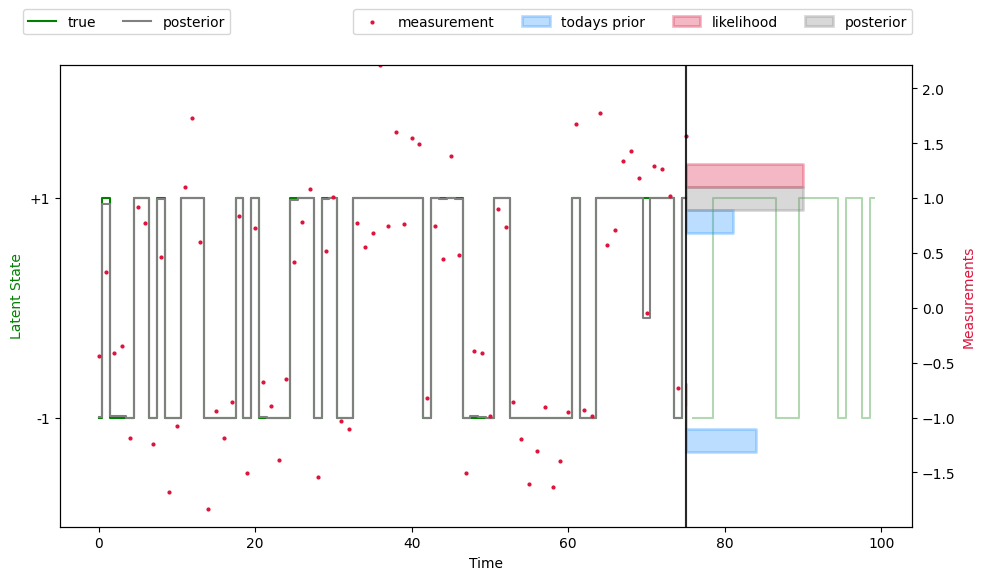

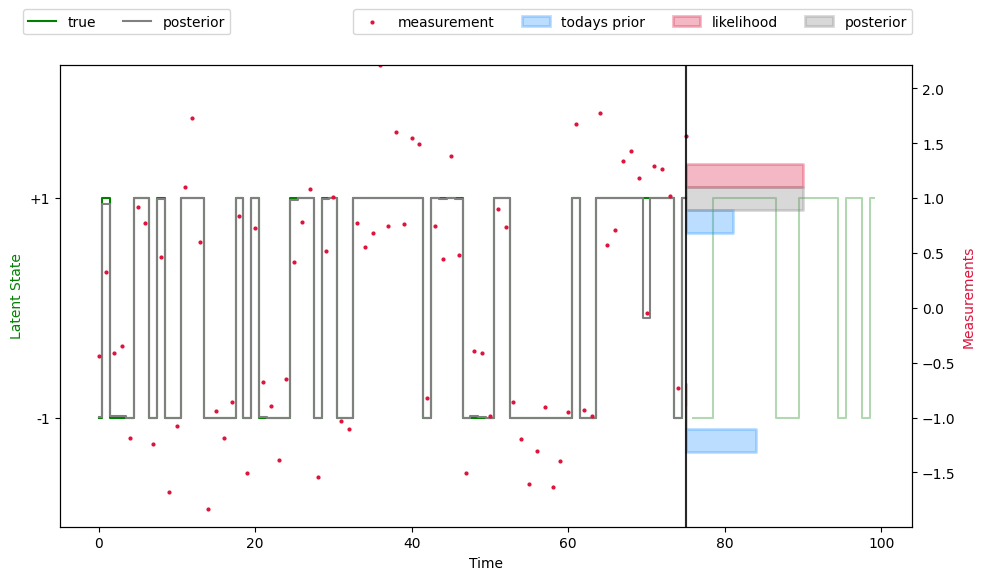

In [51]:
def markov_forward(p0, D):
    """Calculate the forward predictive distribution in a discrete Markov chain
  
    Args:
      p0 (numpy vector): a discrete probability vector
      D (numpy matrix): the transition matrix, D[i,j] means the prob. to
      switch FROM i TO j
  
    Returns:
      p1 (numpy vector): the predictive probabilities in next time step
    """
    ##############################################################################

    # Calculate predictive probabilities (prior)
    p1 = p0 @ D 

    return p1

def one_step_update(model, posterior_tm1, M_t):
    """Given a HMM model, calculate the one-time-step updates to the posterior.
    Args:
      model (GaussianHMM1D instance): the HMM
      posterior_tm1 (numpy vector): Posterior at `t-1`
      M_t (numpy array): measurement at `t`
  
    Returns:
      posterior_t (numpy array): Posterior at `t`
    """

    # Calculate predictive probabilities (prior)
    prediction = markov_forward(posterior_tm1, model.transmat)

    # Get the likelihood
    likelihood = compute_likelihood(model, M_t)

    # Calculate posterior
    posterior_t = likelihood * prediction

    # Normalize
    posterior_t /= np.sum(posterior_t)

    return prediction, likelihood, posterior_t


# Set random seed
np.random.seed(12)

# Set parameters
switch_prob = 0.4
noise_level = .4
t = 75

# Create and sample from model
model = create_HMM(switch_prob = switch_prob,
                   noise_level = noise_level,
                   startprob=[0.5, 0.5])

measurements, states = sample(model, nstep)

# Infer state sequence
predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(model, nstep,
                                                                            measurements)
states_inferred = np.asarray(posterior_probs[:,0] <= 0.5, dtype=int)

# Visualize
plot_forward_inference(
    model, states, measurements, states_inferred,
    predictive_probs, likelihoods, posterior_probs,t=t, flag_m = 0
)

In [52]:
nstep = 100

@widgets.interact
def plot_forward_inference_widget(
        switch_prob=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.05),
        log10_noise_level=widgets.FloatSlider(min=-1., max=1., step=.01, value=0.1),
        t=widgets.IntSlider(min=0, max=nstep-1, step=1, value=nstep//2),
        flag_d=widgets.Checkbox(value=True, description='measurements',
                                disabled=False, indent=False),
        flag_pre=widgets.Checkbox(value=True, description='todays prior',
                                  disabled=False, indent=False),
        flag_like=widgets.Checkbox(value=True, description='likelihood',
                                   disabled=False, indent=False),
        flag_post=widgets.Checkbox(value=True, description='posterior',
                                   disabled=False, indent=False),
):

    np.random.seed(102)

    # global model, measurements, states, states_inferred, predictive_probs, likelihoods, posterior_probs
    model = create_HMM(switch_prob=switch_prob,
                       noise_level=10.**log10_noise_level,
                       startprob=[0.5, 0.5])
    measurements, states = sample(model, nstep)

    # Infer state sequence
    predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(model, nstep,
                                                                                measurements)
    states_inferred = np.asarray(posterior_probs[:,0] <= 0.5, dtype=int)

    fig = plot_forward_inference(
        model, states, measurements, states_inferred,
        predictive_probs, likelihoods, posterior_probs,t=t,
        flag_m=0,
        flag_d=flag_d,flag_pre=flag_pre,flag_like=flag_like,flag_post=flag_post
    )
    plt.show(fig)

interactive(children=(FloatSlider(value=0.05, description='switch_prob', max=1.0, step=0.01), FloatSlider(valu…